In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/postroomtemp/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20240117_Cs137_AC_600V.dat', '20240119_Cs137_AC_600V.dat', '20240122_Cs137_AC_600V.dat', '20240123_Cs137_AC_600V.dat'], \
                       ['20240124_Cs137_DC_600V.dat', '20240125_Cs137_DC_600V.dat', '20240126_Cs137_DC_600V.dat']]}

erange_dict = {'Cs137': [475., 667.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 51)}

# Loop and make depth-calibrated dataframes

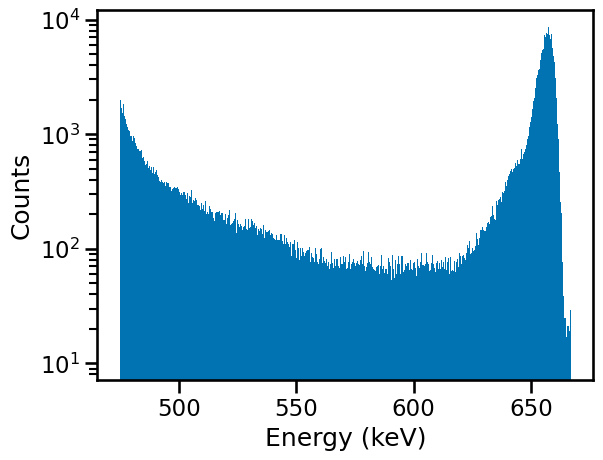

FWHM = 5.92
FWTM = 180.49


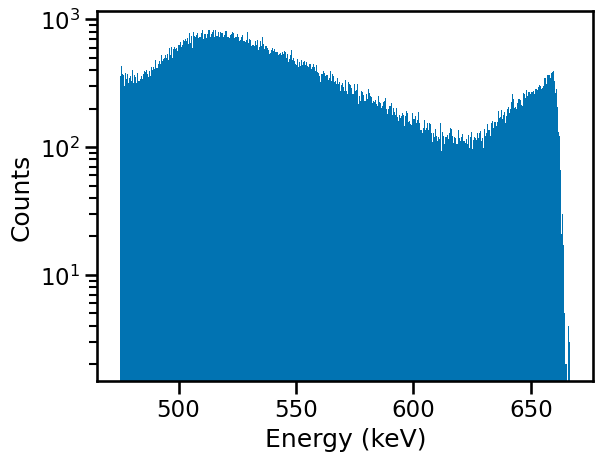

FWHM = 184.28
FWTM = 0.0


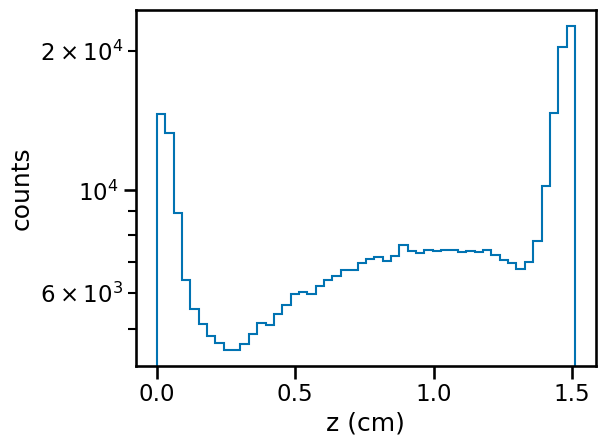

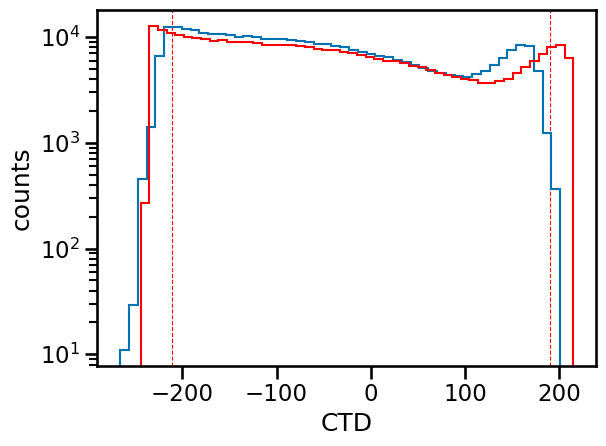

In [4]:
data_dict = {}
for source in file_dict:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allACDC_postroomtemp'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'postroomtemp/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "CTD_" + string + ".pdf")

In [7]:
depth_plot_dict = {}
for source in data_dict:
    string = source + 'allACDC_postroomtemp'
    z_bins, e_trapping, h_trapping = make_depthplot(data_dict[source], string, zbin_dict[source], source=source)
    depth_plot_dict[source] = z_bins, e_trapping, h_trapping
    # depth_correction(data_dict[source], z_bins, e_trapping, h_trapping, plot_suffix = string, source = source)
    with open('./depth_plot_'+string+'.txt', 'wb') as file:
        pickle.dump([z_bins, e_trapping, h_trapping], file)

/home/cosilab/COSITrapping/depth_helpers.py:58: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]


In [8]:
print(depth_plot_dict)

{'Cs137': (array([0.    , 0.0302, 0.0604, 0.0906, 0.1208, 0.151 , 0.1812, 0.2114,
       0.2416, 0.2718, 0.302 , 0.3322, 0.3624, 0.3926, 0.4228, 0.453 ,
       0.4832, 0.5134, 0.5436, 0.5738, 0.604 , 0.6342, 0.6644, 0.6946,
       0.7248, 0.755 , 0.7852, 0.8154, 0.8456, 0.8758, 0.906 , 0.9362,
       0.9664, 0.9966, 1.0268, 1.057 , 1.0872, 1.1174, 1.1476, 1.1778,
       1.208 , 1.2382, 1.2684, 1.2986, 1.3288, 1.359 , 1.3892, 1.4194,
       1.4496, 1.4798, 1.51  ]), [array([0.99641725, 0.99627024, 0.99609392, 0.9964231 , 0.99720901,
       0.99688607, 0.99653415, 0.99634378, 0.99632422, 0.99666049,
       0.99630472, 0.99627179, 0.99651685, 0.99632044, 0.99624325,
       0.99618894, 0.99604779, 0.99586133, 0.99567119, 0.99564068,
       0.99551596, 0.9954927 , 0.995208  , 0.99514244, 0.9950042 ,
       0.99487284, 0.99470933, 0.9944545 , 0.99433784, 0.99420049,
       0.9939119 , 0.99380441, 0.99357157, 0.9934553 , 0.99316994,
       0.99285862, 0.99278946, 0.99247784, 0.99221712, 0.991

In [14]:
trim_index = 1
sim_dCCE_dat = np.loadtxt(sim_dCCE, delimiter=',').T

def e_depth_plot_Cs(z, ae_Cs, b, c):
    CCE = ae_Cs*(1.-b*sim_dCCE_dat[1][::-1])*(1.-c*sim_dCCE_dat[2][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def h_depth_plot_Cs(z, ah_Cs, b, c):
    CCE = ah_Cs*(1.-b*sim_dCCE_dat[3][::-1])*(1.-c*sim_dCCE_dat[4][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

func_dict = {'Cs137': [e_depth_plot_Cs, h_depth_plot_Cs]}

c = cost.Constant(0.0)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.
    
    c += cost.LeastSquares(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index], e_trapping[1][trim_index:-trim_index], func_dict[source][0]) + \
    cost.LeastSquares(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index], 1.0e-3, func_dict[source][1])

m = Minuit(c, ae_Cs=1.0, ah_Cs=1.0, b=1.36, c=1000.)
m.limits["b", "c"] = (0, None)
# m.fixed["b"] = True
m.migrad()
m.hesse()
m.minos()
print(m)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    
    plot_suffix = source + 'allACDC_postroomtemp'
    line_e = source_dict[source]
    
    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]*line_e, fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]*line_e, fmt="x", color='C1')


    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])*line_e, color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])*line_e, color='C1', zorder=0, lw=0.9)

    plt.axhline(line_e, ls='--', color='C2', zorder=0)
    plt.legend()
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    plt.tight_layout()
    # plt.savefig(plot_dir + 'CCE_fit_frozenb_energy_' + plot_suffix + '.pdf')
    plt.savefig(plot_dir + 'CCE_fit_energy_' + plot_suffix + '.pdf')
    plt.close()

    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]/m.values['ae_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]/m.values['ae_'+source[:2]], fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]/m.values['ah_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]/m.values['ah_'+source[:2]], fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]/m.values['ae_'+source[:2]], xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]/m.values['ah_'+source[:2]], xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]/m.values['ah_'+source[:2]], fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]/m.values['ae_'+source[:2]], xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]/m.values['ah_'+source[:2]], xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]/m.values['ah_'+source[:2]], fmt="x", color='C1')

    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])/m.values['ae_'+source[:2]], color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])/m.values['ah_'+source[:2]], color='C1', zorder=0, lw=0.9)

    plt.legend()
    plt.xlabel("Detector Depth (cm)")
    plt.ylabel("CCE")
    plt.ylim(top=1.0)
    plt.tight_layout()
    # plt.savefig(plot_dir + 'CCE_fit_frozenb_norm_' + plot_suffix + '.pdf')
    plt.savefig(plot_dir + 'CCE_fit_norm_' + plot_suffix + '.pdf')
    plt.close()
    # depth_correction_CCE(data_dict[source], *m.values['ae','ah','b','c'], sim_dCCE, plot_suffix = string, source=source)
    # param_dict[source] = m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.566e+04 (chi2/ndof = 822.3)│              Nfcn = 338              │
│ EDM = 9.49e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───